In [1]:
#Getting the dataset
#Source: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package
"""
This dataset contains about 10 years of daily weather observations from many locations across Australia.

RainTomorrow is the target variable to predict. 
It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.
"""
!wget "https://www.dropbox.com/s/5i4470q2xy4daan/weatherAUS.csv"

--2021-07-31 15:16:13--  https://www.dropbox.com/s/5i4470q2xy4daan/weatherAUS.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5i4470q2xy4daan/weatherAUS.csv [following]
--2021-07-31 15:16:13--  https://www.dropbox.com/s/raw/5i4470q2xy4daan/weatherAUS.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9669f4dfd68a954b3ecc8775ba.dl.dropboxusercontent.com/cd/0/inline/BTXZ0JkjRdk5TlnB1d73gNGvPYCEHmpnWlgGb0w2BJ08DcArShAZd0V_bEHErMgeY7KGh557RMUYPO3FA_3moPdK9BmNZalUCsOUCA9huFAZcVgYjvkYssIdzZno2L3c1I0U2Pl_9iXpf3SGWKYlDdFW/file# [following]
--2021-07-31 15:16:14--  https://uc9669f4dfd68a954b3ecc8775ba.dl.dropboxusercontent.com/cd/0/inline/BTXZ0JkjRdk5TlnB1d73gNGvPYCEHmpnWlgGb0w2BJ08DcArShAZd0V_bEHErMgeY7KGh557RMUYPO3FA_3m

In [2]:
#Getting the library
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

In [3]:
!pip install pybbn

  Created wheel for pybbn: filename=pybbn-3.2.1-py3-none-any.whl size=39725 sha256=bd5447a704fa52bf632629b29ef7dbc03d7f69cdf7cdb7efa92cf3331c7c1e3d
  Stored in directory: /root/.cache/pip/wheels/a8/64/55/b52530d41fe7c9ae501ddd7c06f3122ceb5f15921680f0371b
Successfully built pybbn


In [4]:
#pybbn for creating Bayesian Belief Networks
# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [5]:
# Read in the weather data csv
df=pd.read_csv('weatherAUS.csv')

# Drop records where target RainTomorrow=NaN
df=df[pd.isnull(df['RainTomorrow'])==False]

# For other columns with missing values, fill them in with column mean
df=df.fillna(df.mean())

# Create bands for variables that we want to use in the model
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40'   if x<=40 else
                                                            '1.40-50' if 40<x<=50 else '2.>50')
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')

# Show a snaphsot of data
df

Date Location  ...  Humidity9amCat  Humidity3pmCat
0       2008-12-01   Albury  ...           1.>60          0.<=60
1       2008-12-02   Albury  ...          0.<=60          0.<=60
2       2008-12-03   Albury  ...          0.<=60          0.<=60
3       2008-12-04   Albury  ...          0.<=60          0.<=60
4       2008-12-05   Albury  ...           1.>60          0.<=60
...            ...      ...  ...             ...             ...
145454  2017-06-20    Uluru  ...          0.<=60          0.<=60
145455  2017-06-21    Uluru  ...          0.<=60          0.<=60
145456  2017-06-22    Uluru  ...          0.<=60          0.<=60
145457  2017-06-23    Uluru  ...          0.<=60          0.<=60
145458  2017-06-24    Uluru  ...          0.<=60          0.<=60

[142193 rows x 26 columns]

In [ ]:
# Create nodes by manually typing in probabilities
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), [0.30658, 0.69342])
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), [0.92827, 0.07173, 
                                                      0.55760, 0.44240])
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), [0.58660, 0.24040, 0.17300])
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), [0.92314, 0.07686, 
                                                0.89072, 0.10928, 
                                                0.76008, 0.23992, 
                                                0.64250, 0.35750, 
                                                0.49168, 0.50832, 
                                                0.32182, 0.67818])

In [6]:
df['Humidity9amCat'].value_counts(normalize=True)

1.>60     0.693417
0.<=60    0.306583
Name: Humidity9amCat, dtype: float64

In [9]:
df['Humidity9amCat'].value_counts(normalize=False)/len(df)

1.>60     0.693417
0.<=60    0.306583
Name: Humidity9amCat, dtype: float64

In [7]:
df['WindGustSpeedCat'].value_counts(normalize=True)

0.<=40     0.586597
1.40-50    0.240399
2.>50      0.173004
Name: WindGustSpeedCat, dtype: float64

In [ ]:
df['Humidity3pmCat'].value_counts(normalize=True)

0.<=60    0.671243
1.>60     0.328757
Name: Humidity3pmCat, dtype: float64

In [10]:
# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs(data, child, parent1=None, parent2=None):
    # Initialize empty list
    prob=[]
    if parent1==None:
        # Calculate probabilities
        prob=data[child].value_counts(normalize=True, sort=False).sort_index().tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Work out the bands present in the parent variable
                bands=df[parent1].value_counts(sort=False).sort_index().index.tolist()
                # Caclucate probabilities
                for val in bands:
                    temp=data[data[parent1]==val][child].value_counts(normalize=True).sort_index().tolist()
                    prob=prob+temp
            else:    
                # Work out the bands present in the parent variable
                bands1=df[parent1].value_counts(sort=False).sort_index().index.tolist()
                bands2=df[parent2].value_counts(sort=False).sort_index().index.tolist()
                # Caclucate probabilities
                for val1 in bands1:
                    for val2 in bands2:
                        temp=data[(data[parent1]==val1) & (data[parent2]==val2)][child].value_counts(normalize=True).sort_index().tolist()
                        prob=prob+temp
    else: print("Error in Probability Frequency Calculations")
    return prob 

In [11]:
probs(df,"Humidity3pmCat","Humidity9amCat")

[0.928269945405331, 0.071730054594669, 0.5576020040771205, 0.44239799592287954]

In [12]:
probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat')

[0.9231423408100351,
 0.07685765918996491,
 0.8907156673114119,
 0.109284332688588,
 0.7600840888188148,
 0.23991591118118513,
 0.6425022248590923,
 0.35749777514090775,
 0.4916834919719258,
 0.5083165080280743,
 0.3218170185540627,
 0.6781829814459372]

In [13]:
# Create nodes by using our earlier function to automatically calculate probabilities
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df, child='WindGustSpeedCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

# Create Network
bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

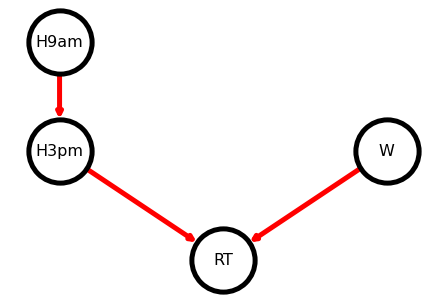

In [14]:
# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

In [15]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.67124
1=>60|0.32876
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.30658
0=>60|0.69342
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.58660
2=40-50|0.24040
2=>50|0.17300
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.77655
3=Yes|0.22345
----------------


In [16]:
"""
We can pass evidence into BBN and see how that affects probabilities for every node in the network.
Let’s say it is 9 am right now, and we have measured the humidity outside. 
It says 72, which obviously belongs to the “>60” band. Hence, let’s pass this evidence into the BBN and see what happens.
Note, below is another small function created to help us with that.
""";

In [20]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
# Use above function to add evidence
evidence('ev1', 'H9am', '>60', 1.0)

# Print marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.67124
1=>60|0.32876
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.30658
0=>60|0.69342
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.58660
2=40-50|0.24040
2=>50|0.17300
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.77655
3=Yes|0.22345
----------------


In [ ]:
"""
As you can see, “Humidity9am>60” is now equal to 100%, and the likelihood of “Humidity3pm>60” has increased from 32.8% to 44.2%. 

At the same time, the chance of “RainTomorrow” has gone up to 26.1%.

Also, note how probabilities for “WindGustSpeed” did not change since “W” and “H9am” are independent of each other.
""";

In [21]:
#Run Above code to remove evidence from network
# 2 New Evidence for H3pm & W
# Add more evidence
evidence('ev1', 'H3pm', '>60', 1.0)
evidence('ev2', 'W', '>50', 1.0)
# Print marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.00000
1=>60|1.00000
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.06689
0=>60|0.93311
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.00000
2=40-50|0.00000
2=>50|1.00000
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.32182
3=Yes|0.67818
----------------
